## Description:
这里是DIEN的一个demo， 主要分为数据读取与处理，模型搭建，模型的训练三大模块

In [8]:
# python基础包
import numpy as np
import pandas as pd
from collections import namedtuple
import matplotlib.pyplot as plt
from random import sample

# 特征处理与数据集划分
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from utils import DenseFeat, SparseFeat, VarLenSparseFeat

# 导入模型
from DIEN import DIEN

# 模型训练相关
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# 一些相关设置
import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## 导入数据

In [5]:
def get_neg_click(data_df, neg_num=10):
    movies_np = data_df['hist_movie_id'].values
    
    movie_list = []
    for movies in movies_np:
        movie_list.extend([x for x in movies.split(',') if x != '0'])

    movies_set = set(movie_list) 

    neg_movies_list = []
    for movies in movies_np:
        hist_movies = set([x for x in movies.split(',') if x != '0'])
        neg_movies_set = movies_set - hist_movies # 集合求差集
        neg_movies = sample(neg_movies_set, neg_num) # 返回的是一个列表
        neg_movies_list.append(','.join(neg_movies))

    return pd.Series(neg_movies_list)

In [6]:
"""读取数据"""
samples_data = pd.read_csv("data/movie_sample.txt", sep="\t", header = None)
samples_data.columns = ["user_id", "gender", "age", "hist_movie_id", "hist_len", "movie_id", "movie_type_id", "label"]

In [9]:
"""数据集"""
X = samples_data[["user_id", "gender", "age", "hist_movie_id", "hist_len", "movie_id", "movie_type_id"]]
y = samples_data["label"]

# 负采样，负采样的时候序列的长度和设置的行为序列长度一样长
# 不用担心会多计算损失，其实在计算损失的时候使用mask，无效的值不会参与计算
X['neg_hist_movie_id'] = get_neg_click(X, neg_num=50)
behavior_len = np.array([len([int(i) for i in l.split(',') if int(i) != 0]) for l in X['hist_movie_id']])

In [10]:
"""构建DIEN模型的输入格式"""
# 这里和DIN相比， 会多出负采样的一列历史行为

X_train = {"user_id": np.array(X["user_id"]), \
        "gender": np.array(X["gender"]), \
        "age": np.array(X["age"]), \
        "hist_movie_id": np.array([[int(i) for i in l.split(',')] for l in X["hist_movie_id"]]), \
        "neg_hist_movie_id": np.array([[int(i) for i in l.split(',')] for l in X["neg_hist_movie_id"]]), \
        "seq_length": behavior_len, \
        "hist_len": np.array(X["hist_len"]), \
        "movie_id": np.array(X["movie_id"]), \
        "movie_type_id": np.array(X["movie_type_id"])}

y_train = np.array(y)

## 模型建立

In [11]:
"""特征封装"""

feature_columns = [SparseFeat('user_id', max(samples_data["user_id"])+1, embedding_dim=8), 
                    SparseFeat('gender', max(samples_data["gender"])+1, embedding_dim=8), 
                    SparseFeat('age', max(samples_data["age"])+1, embedding_dim=8), 
                    SparseFeat('movie_id', max(samples_data["movie_id"])+1, embedding_dim=8),
                    SparseFeat('movie_type_id', max(samples_data["movie_type_id"])+1, embedding_dim=8),
                    DenseFeat('hist_len', 1)]
feature_columns += [VarLenSparseFeat(SparseFeat('hist_movie_id', 
                                                vocabulary_size=max(samples_data["movie_id"])+1,
                                                embedding_dim=8,
                                                embedding_name='item_id'), maxlen=50, length_name='seq_length')]
feature_columns += [VarLenSparseFeat(SparseFeat('neg_hist_movie_id', 
                                                vocabulary_size=max(samples_data["movie_id"])+1,
                                                embedding_dim=8,
                                                embedding_name='item_id'), maxlen=50, length_name='seq_length')]

# 行为特征列表，表示的是基础特征
behavior_feature_list = ['movie_id']
# 行为序列特征
behavior_seq_feature_list = ['hist_movie_id']

In [12]:
"""设置超参数"""
learning_rate = 0.001
batch_size = 64
epochs = 50

In [13]:
"""构建DIN模型"""
model = DIEN(feature_columns, behavior_feature_list, behavior_seq_feature_list, use_neg_sample=True)
model.summary()

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hist_movie_id (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
emb_hist_movie_id (Embedding)   (None, 50, 8)        1680        hist_movie_id[0][0]              
_____

In [14]:
"""模型编译"""
model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=learning_rate), metrics=[AUC()])

## 模型训练

In [15]:
"""模型训练"""
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),   # 早停
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.01, verbose=1)  # 调整学习率
]
history = model.fit(X_train, 
                    y_train, 
                    epochs=epochs, 
                    validation_split=0.2, 
                    batch_size=batch_size,
                    callbacks = callbacks
                   )

Train on 1104 samples, validate on 276 samples
Epoch 1/50
1104/1104 [==============================] - 2s 2ms/sample - loss: 0.9956 - auc: 0.4949 - val_loss: 0.7195 - val_auc: 0.4920
Epoch 2/50
1104/1104 [==============================] - 1s 715us/sample - loss: 0.7071 - auc: 0.4875 - val_loss: 0.6015 - val_auc: 0.4851
Epoch 3/50
1104/1104 [==============================] - 1s 735us/sample - loss: 0.6082 - auc: 0.5047 - val_loss: 0.6469 - val_auc: 0.4373
Epoch 4/50
1104/1104 [==============================] - 1s 753us/sample - loss: 0.6485 - auc: 0.5101 - val_loss: 0.5521 - val_auc: 0.4636
Epoch 5/50
1104/1104 [==============================] - 1s 711us/sample - loss: 0.5577 - auc: 0.5365 - val_loss: 0.5383 - val_auc: 0.2311
Epoch 6/50
1104/1104 [==============================] - 1s 769us/sample - loss: 0.5406 - auc: 0.5497 - val_loss: 0.5449 - val_auc: 0.3400
Epoch 7/50
1104/1104 [==============================] - 1s 714us/sample - loss: 0.5431 - auc: 0.5145 - val_loss: 0.5497 - val_a

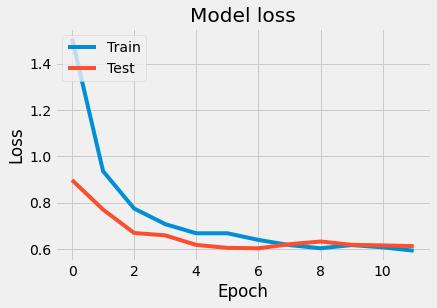

In [10]:
"""可视化下看看训练情况"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 可视化模型架构

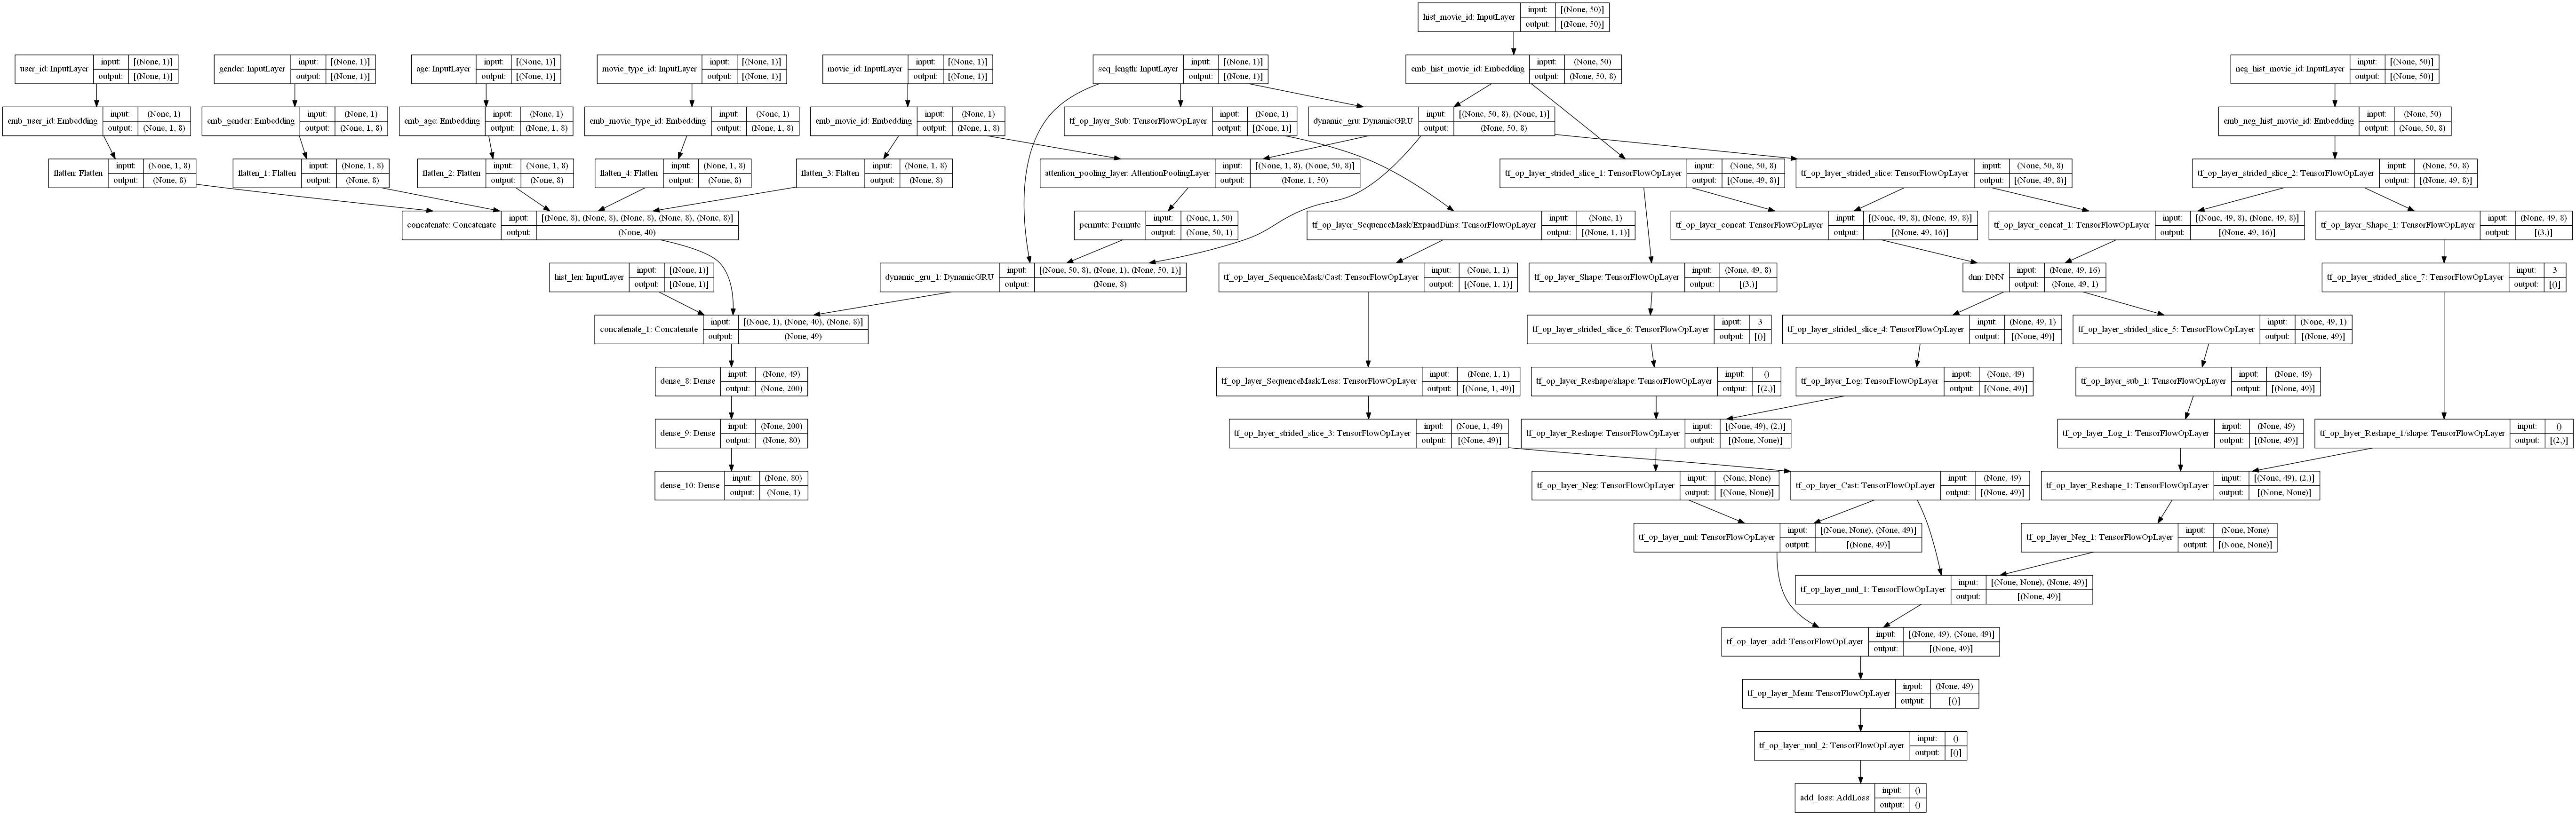

In [16]:
from tensorflow import keras
keras.utils.plot_model(model, to_file='./DIEN.png', show_shapes=True)